In [ ]:

from statsbombpy import sb 
from xgboost import XGBClassifier
import polars as pl
import mplsoccer as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import sys
import warnings

sys.path.append("..")
sys.dont_write_bytecode = True
warnings.filterwarnings("ignore")

In [2]:
from utils.passes_handler import PassesHandler

# Modelling pass difficulties
I believe we can all agree that Pavard's half volley goal was a beautiful, but I the buildup to the goal is also really interesting to look into. Matuidi plays a through ball to Lucas Hernández who then plays a cross at a difficult angle back to Pavard, before he hits a half volley. While the half volley itself requires lots of technique (and luck), I want to answer the following about the passes:
1. Is there a way to quantify the difficulty of the two passes that lead up the goal (i.e. how likely are these types of passes to succeed?)
2. If yes, which pass was more difficult to make (has a lower probability of success)?

Fortunately, there are lots of data related to passes in the ``statsbombpy`` API which we can leverage to adopt a data-driven approach to answer our questions. The plan is to build a model that can tell us give us a pass difficulty score $p_\text{pass}$ for a pass from point $(x_1, y_1)$ to $(x_2, y_2)$ on the pitch. 

# Getting the data


In [3]:
wc2018_matches_df = sb.matches(competition_id=43, season_id=3).sort_values(
    "match_date", ascending=False
)
wc2018_matches = pl.from_pandas(wc2018_matches_df)
match_ids = wc2018_matches.select("match_id").to_series().to_list()

In [4]:
passes_handler = PassesHandler(match_ids=match_ids)

passes_df = passes_handler.get_passes_from_match_ids()

100%|██████████| 64/64 [00:43<00:00,  1.48it/s]


Now that we have generated a .csv file, let us just simply load that.

In [5]:
passes_df = pl.read_csv("../data/02-analysis/passes.csv")

# Exploring the data
Let us take a quick look at the data and what each feature stands for according to the official [documentation](https://github.com/statsbomb/statsbombpy/blob/master/doc/Open%20Data%20Events%20v4.0.0.pdf):

- ``start_x``: x coordinate of the pass origin (where the pass started)
- ``start_y``: y coordinate of the pass origin
- ``end_x``: x coordinate of the pass destination (where the pass ended)
- ``end_y``: y coordinate of the pass destination
- ``length``: length of the pass in yards
- ``height``: the height type of the pass (e.g., Ground Pass, Low Pass, High Pass)
- ``angle``: angle of the pass in radians, with 0 pointing straight ahead. Values between 0 and $\pi$ indicating an angle clockwise.
- ``duration``: the length the event lasted in seconds
- ``body_part``: which body part was used to make the pass (Head, Left foot, Right foot, Other)
- ``under_pressure``: Boolean indicating whether the player making the pass was under pressure by other players
- ``outcome``: result of the pass (e.g., Incomplete, Out, Pass offside, null if completed). This is our target variable.

There is also the ``match_id`` column, but we will not use that as an actual feature in our model.

In [8]:
passes_df.describe()

statistic,match_id,start_x,start_y,end_x,end_y,length,height,angle,duration,body_part,under_pressure,outcome
str,f64,f64,f64,f64,f64,f64,str,f64,f64,str,f64,str
"""count""",62881.0,62881.0,62881.0,62881.0,62881.0,62881.0,"""62881""",62881.0,62881.0,"""59654""",13029.0,"""12714"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,"""3227""",49852.0,"""50167"""
"""mean""",7699.567644,60.040664,40.442868,66.698271,40.275393,21.316443,null,0.025414,1.514009,null,1.0,null
"""std""",369.805902,26.9003,24.024639,26.835943,23.793187,14.863208,null,1.559887,0.871668,null,null,null
"""min""",7525.0,1.0,1.0,1.0,1.0,0.0,"""Ground Pass""",-3.120319,0.0,"""Drop Kick""",1.0,"""Incomplete"""
"""25%""",7544.0,40.0,20.0,47.0,20.0,11.18034,null,-1.19029,0.933,null,null,null
"""50%""",7560.0,59.0,40.0,66.0,40.0,17.464249,null,0.0,1.293,null,null,null
"""75%""",7580.0,80.0,61.0,87.0,61.0,27.018513,null,1.2490457,1.84,null,null,null
"""max""",8658.0,120.0,80.0,120.0,80.0,108.66922,"""Low Pass""",3.1415927,8.56,"""Right Foot""",1.0,"""Unknown"""


The ``null_count`` row tells us that the features ``body_part``, ``under_presssure`` and ``outcome`` have null values which will affect our choice of model.

In total, we have 10 features and the target variable. Out of the 10 features, 7 are continious, 2 are categorical and 1 is binary. Let us try to plot the correlation between the continious features.



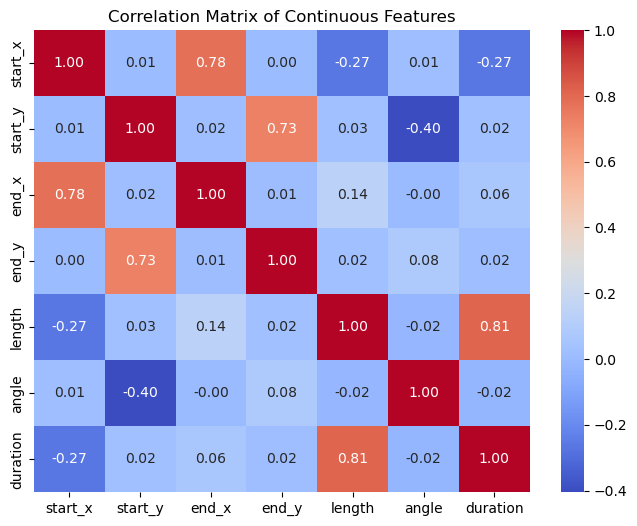

In [11]:
# Compute correlation matrix for continuous features in passes_df
continuous_cols = ["start_x", "start_y", "end_x", "end_y", "length", "angle", "duration"]
corr_matrix = passes_df.select(continuous_cols).to_pandas().corr()


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Continuous Features")
plt.show()

From the matrix plot, we can observe that ``duration`` and ``length`` are highly positively correlated. There is also a high correlation between ``start_x`` and ``end_x`` and ``start_y`` and ``end_y``. There is also a significant inverse relationship ``start_x`` with ``length`` and ``duration`` and ``start_y`` and ``angle``. 